In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bridgestan as bs
from posteriordb import PosteriorDatabase

from mcmctoolbox.functoolbox import flat

from mcmclib.metropolis import mala_adapt

In [2]:
# Load DataBase Locally
pdb_path = "/home/congye/Code/PythonProjects/LearningAdaptiveMCMC/Python/posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-SimpleEggBox-test-SimpleEggBox")
stan_code = posterior.model.stan_code_file_path()
# stan_data = json.dumps(posterior.data.values())
stan_data = json.dumps({"sigma": 1, "r": 20})
model = bs.StanModel.from_stan_file(stan_code, stan_data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]

In [3]:
nits = 100_000
x0 = np.array([0.0, 0.0])
h0 = 0.1
c0 = np.eye(2)
alpha = 10 * [0.3]
epoch = 9 * [nits] + [nits]
x, g, p, a, h, c = mala_adapt(log_p, grad_log_p, x0, h0, c0, alpha, epoch, pb=True)

100%|██████████| 9/9 [02:31<00:00, 16.86s/it]


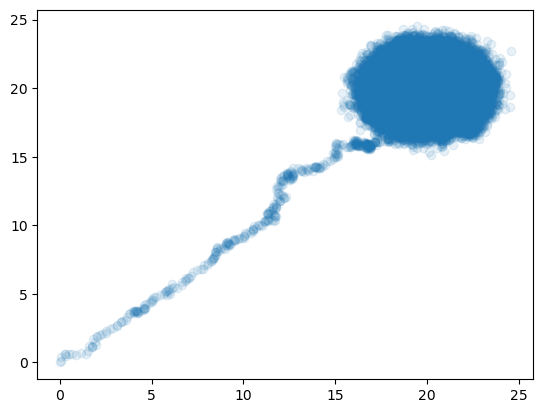

In [11]:
plt.plot(np.array(x).reshape(-1, 2)[:, 0], np.array(x).reshape(-1, 2)[:, 1], 'o', alpha=0.1)

In [16]:
c

array([[1.00379723, 0.00128881],
       [0.00128881, 1.00185453]])